In [194]:
#This notebook performs the NLP (tokenizing, vectorization, and LDA) and saves matrices (DataFrames) for use in the flask app.

In [1]:
import numpy as np
import pandas as pd
import pickle
import re

In [ ]:
with open('general_stop_words.pickle', 'rb') as to_read:
    general_stop_words = pickle.load(to_read)
to_read.close()

In [ ]:
import MeCab
mt = MeCab.Tagger("-r /dev/null -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd/")



In [ ]:
def count_vectorizer(text,stop_words={},bigrams=False):
    counts={}
    word_list=[]
    for item in mt.parse(text).split('\n')[:-2]:
        word = item.split('\t')[0]
        if re.match('([a-zA-Z0-9.:\/]+|.+[市村町区駅]$)',word):continue
        if item.split('\t')[1].split(',')[0] in ['名詞','形容詞']:
            if word not in stop_words:
                if word not in counts.keys(): counts[word] = 0
                counts[word] += 1
                if bigrams: word_list.append(word)
    if bigrams:
        for i,word in enumerate(word_list[:-1]):
            bigram = word+word_list[i+1]
            if bigram not in counts.keys(): counts[bigram] = 0
            counts[bigram] += 1    
    return pd.Series(counts)

Adding the most basic place names in the region and some ways of writing the work "ramen"

In [ ]:
custom_stop_words={'コロナ','新潟県','富山県','石川県','福井県','山梨県','長野県','岐阜県','静岡県','愛知県',
    '新潟','富山','石川','福井','山梨','長野','岐阜','静岡','愛知','ラーメン','らーめん'}

In [ ]:
stop_words = general_stop_words | custom_stop_words

In [193]:
#Combine all review comments from the same shop into a single document

SyntaxError: invalid syntax (<ipython-input-193-29401bd53702>, line 1)

In [ ]:
def shop_total(shop_reviews):
    return pd.concat([count_vectorizer(review,
        stop_words) for review in shop_reviews],axis=1).transpose().sum()

In [ ]:
prefecture_list = ['aichi','fukui','yamanashi','nagano','gifu',
                   'shizuoka','niigata','toyama','ishikawa']

total_word_counts={}

for prefecture in prefecture_list:
    try:
        with open(f'{prefecture}_ramen_風.pickle', 'rb') as to_read:
            reviews_dict,urls = pickle.load(to_read)
        to_read.close()
    except:
        with open(f'{prefecture}_ramen.pickle', 'rb') as to_read:
            reviews_dict = pickle.load(to_read)
        to_read.close()
        
        with open(f'{prefecture}_ramen_風.pickle', 'rb') as to_read:
            urls = pickle.load(to_read)
        to_read.close()
    reviews=pd.Series(reviews_dict)
    print(f'read in {prefecture} reviews')
    count_vectorized=pd.concat([shop_total(shop_reviews) for shop_reviews in reviews if len(shop_reviews) > 0],
        axis=1).transpose()
    count_vectorized['url'] = [url for i,url in enumerate(urls) if len(reviews[i]) > 0]
    
    print(f'got {prefecture} reviews')
    with open(f'{prefecture}vectorized.pickle', 'wb') as to_write:
        pickle.dump((count_vectorized), to_write)
    to_write.close()
    sums = count_vectorized.drop('url',axis=1).sum()
    for word in sums.index:
        if word not in total_word_counts.keys(): total_word_counts[word] = 0
        total_word_counts[word]+=sums[word]
    with open('total_word_counts.pickle', 'wb') as to_write:
        pickle.dump((total_word_counts), to_write)
    to_write.close()
    del count_vectorized

In [ ]:
with open('total_word_counts.pickle', 'rb') as to_read:
    total_word_counts = pickle.load(to_read)
to_read.close()
word_counts_series=pd.Series(total_word_counts)
drop_words = word_counts_series[word_counts_series <= 7].index

In [ ]:
prefecture_list = ['aichi','fukui','yamanashi','nagano','gifu',
                   'shizuoka','niigata','toyama','ishikawa']
total_df=pd.DataFrame()
for prefecture in prefecture_list:
    with open(f'{prefecture}vectorized.pickle', 'rb') as to_read:
        df = pickle.load(to_read)
    to_read.close()
    df['変な言葉'] = df[list(set(df.columns)& set(drop_words))].sum(axis=1)
    df.drop(list(set(df.columns)& set(drop_words)),axis=1,inplace=True)
    df.fillna(0,inplace=True)
    total_df = pd.concat([total_df,df],ignore_index=True)

In [ ]:
total_df.fillna(0,inplace=True)
total_df=total_df.groupby('url').max()
with open('identity.pickle', 'rb') as to_read:
        info = pickle.load(to_read)
to_read.close()
identity = pd.DataFrame(info).transpose()
bad_set=set(identity.index)^set(total_df.index)
identity=identity.drop((bad_set&set(identity.index)),axis=0).sort_index(
    ).reset_index()
identity.columns=['url','name','rating','latitude','longitude']
total_df = total_df.reset_index().set_index('url').drop((bad_set&
    set(total_df.index)),axis=0).sort_index().reset_index().drop('url',axis=1)
identity['rating']=identity['rating'].astype('float64')
identity['latitude']=identity['latitude'].astype('float64')
identity['longitude']=identity['longitude'].astype('float64')

In [ ]:
with open('total_df.pickle', 'wb') as to_write:
    pickle.dump((total_df), to_write)
to_write.close()
with open('identity_df.pickle', 'wb') as to_write:
    pickle.dump((identity), to_write)
to_write.close()

In [2]:
with open('total_df.pickle', 'rb') as to_read:
    total_df = pickle.load(to_read)
to_read.close()
with open('identity_df.pickle', 'rb') as to_read:
    identity = pickle.load(to_read)
to_read.close()

Try some numbers of topics to see what works best

In [ ]:
perplexed={}
for i in range(1,25):
    print(i)
    lda = LatentDirichletAllocation(n_components=i,learning_method='online',batch_size=512,max_iter=25,learning_decay=.7,mean_change_tol=0.1)
    lda.fit(total_df)
    perplexed[i]=lda.perplexity(total_df)

<ipython-input-190-8f3612804135>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


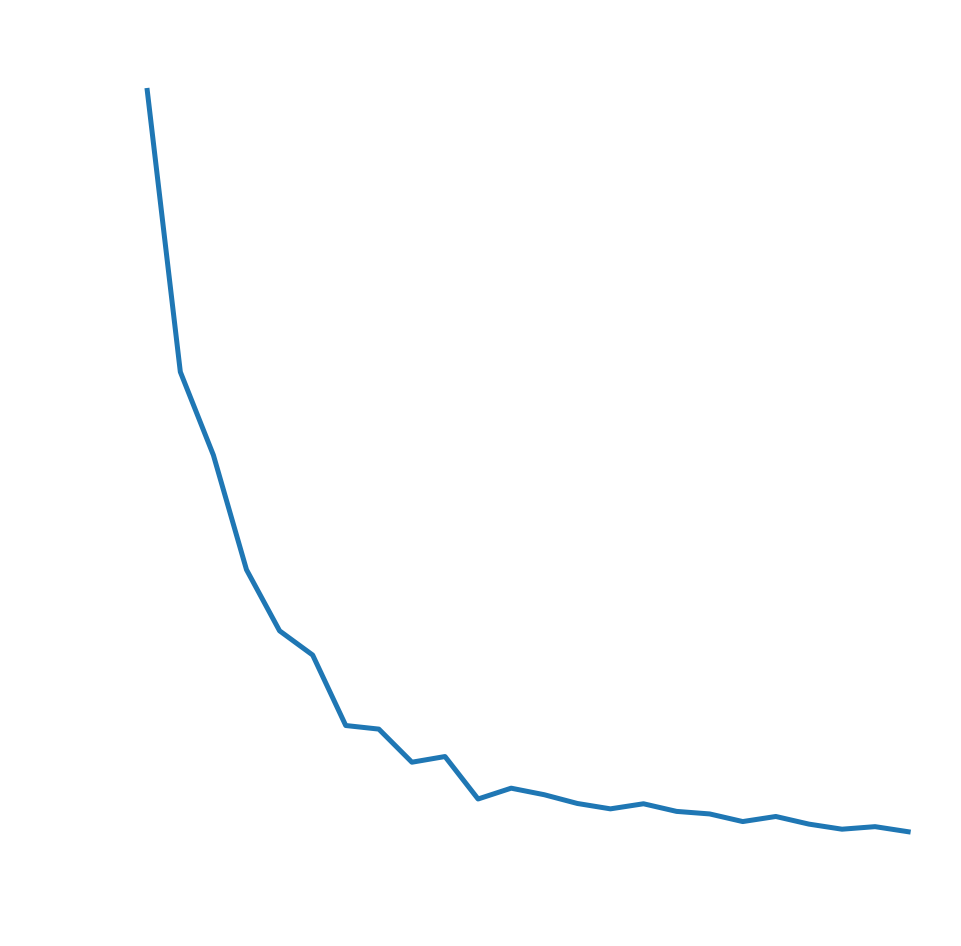

In [190]:
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.plot(pd.Series(perplexed).index,pd.Series(perplexed),linewidth=5)
plt.xlabel('Number of Topics',fontsize=40,color='white')
plt.ylabel('Perplexity',fontsize=40,color='white')
plt.title('LDA Perplexity by Number of Topics',fontsize=48,color='white')
ax=plt.axes()
ax.set_facecolor('#00000000')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors="white")
ax.tick_params(axis='y', colors="white")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('./media/LDA_Perplexity.png')

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10,learning_method='online',batch_size=512,max_iter=1000,learning_decay=.7,mean_change_tol=0.01,evaluate_every=10,verbose=True)
lda.fit(total_df)

In [177]:
topic_document = pd.DataFrame(lda.transform(total_df))
topic_document['name']=identity['name']
topic_document['url']=identity['url']
topic_document

,0,1,2,3,4,5,6,7,8,9,name
0,0.000027,0.000027,0.038497,0.151354,0.000027,0.006376,0.083520,0.102565,0.617580,0.000027,ほくと亭
1,0.000018,0.005916,0.035378,0.143282,0.000018,0.494575,0.216042,0.068663,0.036091,0.000018,なご家
2,0.000019,0.000019,0.000019,0.077933,0.007955,0.304259,0.065285,0.542849,0.001645,0.000019,江南本店
3,0.000030,0.306635,0.000030,0.170088,0.023367,0.000030,0.187524,0.148229,0.164035,0.000030,熊ちゃんの店名駅店
4,0.000019,0.003371,0.000019,0.110904,0.005586,0.223309,0.326244,0.311573,0.018957,0.000019,萬珍軒
...,...,...,...,...,...,...,...,...,...,...,...
6410,0.018609,0.000142,0.000142,0.062241,0.205173,0.000142,0.000142,0.713125,0.000142,0.000142,真味
6411,0.002300,0.000077,0.359804,0.000077,0.017171,0.328881,0.000077,0.108903,0.182634,0.000077,ラーメン大皇
6412,0.000080,0.083802,0.021079,0.000080,0.000080,0.085552,0.027105,0.125386,0.649247,0.007588,麺場田所商店談合坂サービスエリア店
6413,0.010554,0.000145,0.341473,0.000145,0.000145,0.623997,0.020213,0.000145,0.003040,0.000145,鶏だし中華そば百蔵談合坂店


In [178]:
id2word = list(total_df.columns)
word_topic=pd.DataFrame(lda.components_,columns=id2word)
for col in word_topic.columns:
    word_topic[col]=word_topic[col]/word_topic[col].sum()
word_topic

,店,醤油ラーメン,筋,アワード,醤油,部門,金賞,受賞,情報,訪問,...,アルプラザ金沢,トラックステーション,にんたまラーメン,羽咋,天水,赤帯,南新保,カジマート,辰口,手取フィッシュランド
0,0.010519,0.000729,0.000369,0.011650,0.000002,0.000370,0.002828,0.000783,0.002861,0.000003,...,0.011575,0.010423,0.008026,0.005224,0.952985,0.011575,0.008693,0.009479,0.007457,0.008693
1,0.122885,0.003651,0.128852,0.382909,0.025346,0.176847,0.002826,0.021664,0.112068,0.143400,...,0.011575,0.010423,0.008026,0.005224,0.005224,0.011576,0.008693,0.009479,0.007457,0.008693
2,0.001523,0.019269,0.034439,0.011650,0.006947,0.033905,0.002828,0.326589,0.014158,0.004754,...,0.011575,0.906191,0.927761,0.889471,0.005224,0.011575,0.008693,0.009479,0.007460,0.008694
3,0.091705,0.008081,0.000369,0.011650,0.032905,0.000370,0.002826,0.050567,0.036982,0.081605,...,0.011575,0.010424,0.008027,0.005224,0.005224,0.011575,0.921765,0.914684,0.007458,0.008693
4,0.168914,0.025452,0.261265,0.011650,0.030086,0.023558,0.859776,0.001831,0.205648,0.118883,...,0.127139,0.010423,0.008027,0.068737,0.005224,0.011575,0.008693,0.009479,0.932876,0.921759
5,0.214608,0.368830,0.297719,0.523889,0.444464,0.520903,0.076328,0.251939,0.300378,0.268268,...,0.011576,0.010423,0.008026,0.005224,0.005224,0.011575,0.008693,0.009479,0.007457,0.008693
6,0.051855,0.025948,0.115879,0.011650,0.018213,0.000370,0.002826,0.000783,0.034794,0.023919,...,0.011576,0.010423,0.008026,0.005224,0.005224,0.011575,0.008693,0.009480,0.007457,0.008693
7,0.137766,0.136817,0.000369,0.011650,0.061937,0.130619,0.002827,0.330091,0.080376,0.126775,...,0.011585,0.010423,0.008027,0.005225,0.005225,0.011576,0.008693,0.009480,0.007461,0.008697
8,0.194041,0.381579,0.160371,0.011650,0.366671,0.112688,0.044107,0.014971,0.206254,0.221001,...,0.780249,0.010424,0.008027,0.005224,0.005224,0.895823,0.008694,0.009480,0.007459,0.008694
9,0.006184,0.029645,0.000369,0.011651,0.013428,0.000370,0.002827,0.000783,0.006481,0.011391,...,0.011575,0.010423,0.008026,0.005224,0.005224,0.011575,0.008693,0.009479,0.007457,0.008693


In [179]:
category_word = pd.DataFrame()
for number in word_topic.index:
    category_word[number]=(word_topic.iloc[number,:]).sort_values(ascending=False).head(50).index

In [180]:
category_word.columns=['Tantanmen','Meat/Curry','Rich','Chinese/Vietnamese','Basic',
                       'Gyoza-Focused','Indie','Chicken/Fish Broth','Nagoya','Travel/Resort']
category_word

,Tantanmen,Meat/Curry,Rich,Chinese/Vietnamese,Basic,Gyoza-Focused,Indie,Chicken/Fish Broth,Nagoya,Travel/Resort
0,上田,台湾まぜそば,ＳＡ,一風堂,カツ丼,大喜,ハラミ,天津飯,ラーメンショップ,長岡
1,くるまやラーメン,丸和,ＰＡ,ベトコン,カツカレー,丸鶏,牛骨ラーメン,エビチリ,ラーショ,青島
2,ハルピン,まぜそば,オッチャホイ,白丸,カツ,志太,万楽,台湾料理,吉村家,小千谷
3,テンホウ,あつもり,売店,ハリガネ,かつ丼,大石,高麗人参,油淋鶏,どさん子,ヒグマ
4,山賊,はなび,さざえ,鶴亀,焼肉定食,塩そ,まるたか,麻婆飯,吉相,安養寺
5,ハルピンラーメン,嘉六,談合坂,ベトコンラーメン,エビフライ,いりこ,老麺,浜松餃子,六角家,宮内
6,塩尻,ジロー,カレーパン,国士無双,ヒレカツ,ニボニボ,歓楽街,麻婆豆腐,麦味噌,長岡生姜醤油ラーメン
7,諏訪湖,やもり,ヤギ,一番星,とん汁,呈,敦賀ラーメン,エビマヨ,しゃが,黒部ダムカレー
8,長野県内,らいこう,フードコート,三太,カキフライ,支那そばや,スッポン,四川料理,こまどり,黒部ダム
9,左近,熱盛り,飛騨牛,神明,チキンライス,伊吹,酔客,辣担,西山製麺,魚沼


In [175]:
with open('all.pkl', 'wb') as to_write:
    pickle.dump((category_word,topic_document,word_topic,identity), to_write)
to_write.close()